- pip install networkx
- pip install shapely
- pip install bezier
- pip install cairosvg
- pip install moviepy
- pip install matplotlib
- pip install svgpathtools

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os

import numpy as np
import math
import networkx as nx
import torch.optim as optim
import IPython.display as ipd

from deepsvg.svglib.geom import Point
from deepsvg.svglib.svg import SVG
from deepsvg.svglib.svg_path import SVGPath
from deepsvg.svglib.utils import to_gif

from deepsvg.difflib.tensor import SVGTensor
from deepsvg.difflib.utils import *
from deepsvg.difflib.loss import *

from moviepy.editor import ImageClip, concatenate_videoclips, ipython_display
from svgpathtools import svg2paths, wsvg
from PIL import Image
from shapely.geometry import Polygon
from shapely.affinity import scale

/home/ivy8792/anaconda3/envs/graph/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


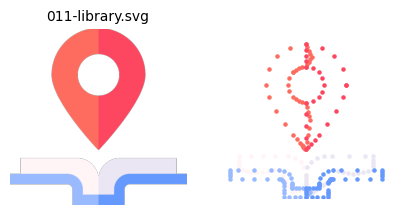

In [2]:
svg_folder = './datasets/svg'
png_folder = './datasets/png'
# colors = [plt.cm.tab20(x) for x in range(20)]

for root, folders, files in os.walk(svg_folder):
    for file in files:
        if file.split('.')[1] != 'svg': continue
        if 'checkpoint' in file: continue
        
        #####
        # file = "037-time.svg"
        file = "011-library.svg"
        
        # svg_folder = './'
        # file = "001-sunset.svg"

        file_path = os.path.join(svg_folder, file)
        svg = SVG.load_svg(file_path).normalize().zoom(0.9)  # .canonicalize().simplify_heuristic()
        svg_target, group_svg_target = svg.to_tensor()
        new_group = []
        colors = []
        
        for i, g in enumerate(group_svg_target):
            new_group.append(SVGTensor.from_data(g))
            colors.append(svg.colors[i])
            
        png_name = file.replace('svg', 'png')
        png = Image.open(os.path.join(png_folder, png_name))
        plt.figure(figsize=(5, 3))
        plt.subplot(121)
        plt.title(file, fontsize=10)
        plt.axis('off')
        plt.imshow(png)
            
        plt.subplot(122)
        plt.axis([0, 25, 23, 0])
        points = []
        for i, g in enumerate(new_group):
            p_target = g.sample_points(n=5)
            points.append(p_target)
            # points.append(p_target.tolist())
            for p in p_target:
                plot_points(p, colors[i], show_color=False)
        plt.close
        break  ##########

## set each point as a node
#### original nodes and group edges

In [3]:
# graph init (add nodes)
num = 0
for p in points:
    num += len(p)
    
nodes = {
    node: {
        "pos": []
    } for node in range(num)
}

G_point = nx.Graph()  # set each point as a node
G_group = nx.Graph()  # for checking edges between clusters
node_group = {}  # {cluster idx: [node group idx]}
node_id = 0  # iter node idx
cluster_id = 0  # iter cluster idx

for i, groups in enumerate(points):
    h = colors[i].lstrip('#')
    if len(h) == 3: h *= 2
    rgb = list(int(h[i:i+2], 16)/255 for i in (0, 2, 4))
    
    for group in groups:
        temp = []  # store node idx in the same group       
        for p in group: 
            features = {
                "rgb": np.array(rgb),
                "pos": np.array(p),
                "origin_cluster": cluster_id,
            }
            
            nodes[cluster_id]["pos"].append(p.cpu().tolist())
            G_point.add_node(node_id, features=features)
            temp.append(node_id)
            node_id += 1
          
        nodes[cluster_id]["rgb"] = rgb  
        node_group[cluster_id] = temp
        cluster_id += 1
        
# build G_group
for node in nodes:
    features = {
        "rgb": nodes[node]["rgb"],
        "pos": np.array(np.array(nodes[node]["pos"]))
    }
    G_group.add_node(node, features=features)

In [4]:
# add edges for each node
edge_type = {}  # {(n1, n2): type of connection}
for k, v in node_group.items():
    for i in range(len(v)-1):
        G_point.add_edge(v[i], v[i+1])
        G_point.add_edge(v[i], v[i])  # self
        
        edge_type[(v[i], v[i+1])] = "group"
        edge_type[(v[i], v[i])] = "self"
       
    G_point.add_edge(v[-1], v[-1])  # self 
    G_point.add_edge(v[0], v[-1])  # first and last points
    edge_type[(v[0], v[-1])] = "group"
    edge_type[(v[-1], v[-1])] = "self"

#### merge clusters
- mirror or symmetric
- color and minimum distance

In [5]:
# check mirror or symmetric
def check_symmetric(n1, n2, shape1, shape2):
    # flip the blocks
    mean1 = np.mean(shape1 ,axis=0)[0]
    mean2 = np.mean(shape2 ,axis=0)[0]
    flip_x = (mean1 + mean2) / 2
    poly1 = Polygon(shape1.tolist())
    poly2 = Polygon(shape2.tolist())
    # if abs(mean1 - mean2) > 1:
    if mean1 < mean2:  # shape1 is on the left
        left = scale(poly1, xfact=-1, origin=(flip_x, 0)).buffer(0.01)  # to avoid self-intersection
        right = poly2.buffer(0.01)
        new_color = G_group.nodes[n1]['features']['rgb']
    else:  # shape2 is on the left
        left = scale(poly2, xfact=-1, origin=(flip_x, 0)).buffer(0.01)
        right = poly1.buffer(0.01)
        new_color = G_group.nodes[n2]['features']['rgb']
    # display(left, right)
        
    # calculate iou
    intersect = left.intersection(right).area
    union = left.union(right).area
    iou = intersect / union   
    if iou > 0.6:
        temp_pair[(n1, n2)] = np.array(new_color)
    # print(n1, n2, iou)
    
# merge
def merge_cluster(merge_pair):
    G = nx.Graph()
    new_node_group = {}
    cluster_id = 0
    done_list = []  # store already merge cluster idx
    
    for pos, rgb in merge_pair.items():
        new_node_group[cluster_id] = []
        for n in pos:
            done_list.append(n)
            new_node_group[cluster_id] += node_group[n]  # update node_group
        
        # update G_group
        temp = []
        for i in new_node_group[cluster_id]:
            G_point.nodes[i]['features']['rgb'] = rgb  # update point ground truth color
            temp.append(G_point.nodes[i]['features']['pos'])
        features = {
            "pos": np.array(temp),
            "rgb": rgb,
        }
        G.add_node(cluster_id, features=features)
        cluster_id += 1          
        
    # not merged blocks
    for i in G_group.nodes:
        if i not in done_list:
            new_node_group[cluster_id] = node_group[i]  # update node_group
            done_list.append(i)  # update done_list
            
            features = {
                "pos": G_group.nodes[i]['features']['pos'],
                "rgb": np.array(G_group.nodes[i]['features']['rgb'])
            }
            G.add_node(cluster_id, features=features)
            cluster_id += 1
            
    return G, new_node_group
    
# check mirror or symmetric
temp_pair = {}
merge_pair = {}  # {(n1, n2): new color}
for n1 in range(len(G_group.nodes)):
    for n2 in range(n1+1, len(G_group.nodes)):
        shape1 = G_group.nodes[n1]['features']['pos']
        shape2 = G_group.nodes[n2]['features']['pos']
        check_symmetric(n1, n2, shape1, shape2)
        
for k, v in temp_pair.items():
    not_append = True
    n1, n2 = min(k), max(k)
    for kk, vv in merge_pair.items():
        if n1 in kk and n2 in kk:
            not_append = False
            break
        if n1 in kk:
            new_key = list(kk)
            new_key.append(n2)
            merge_pair[tuple(new_key)] = np.array(vv)
            del merge_pair[kk]
            not_append = False
            break
    if not_append:
        merge_pair[(n1, n2)] = np.array(G_group.nodes[k[0]]['features']['rgb'])
G_group, node_group = merge_cluster(merge_pair)

In [6]:
# check color and min distance
def check_distance(n1, n2, shape1, shape2, rgb):
    min_dis = float('inf')
    for i in range(len(shape2)):
        dis = math.sqrt(np.sum((shape2[i]-shape1)**2, axis=1).min())
        if dis < min_dis:
            min_dis = dis
    if min_dis < 2:
        temp_pair[(n1, n2)] = np.array(rgb)

# check color and min distance
temp_pair = {}
merge_pair = {}
for n1 in range(len(G_group.nodes)):
    for n2 in range(n1+1, len(G_group.nodes)):
        rgb1 = G_group.nodes[n1]['features']['rgb']
        rgb2 = G_group.nodes[n2]['features']['rgb']
        shape1 = G_group.nodes[n1]['features']['pos']
        shape2 = G_group.nodes[n2]['features']['pos']
        if (rgb1==rgb2).all():
            check_distance(n1, n2, shape1, shape2, rgb1)
            
for k, v in temp_pair.items():
    not_append = True
    n1, n2 = min(k), max(k)
    for kk, vv in merge_pair.items():
        if n1 in kk and n2 in kk:
            not_append = False
            break
        if n1 in kk:
            new_key = list(kk)
            new_key.append(n2)
            merge_pair[tuple(new_key)] = np.array(vv)
            del merge_pair[kk]
            not_append = False
            break
    if not_append:
        merge_pair[(n1, n2)] = np.array(G_group.nodes[k[0]]['features']['rgb'])
G_group, node_group = merge_cluster(merge_pair)

#### add edges between clusters

In [7]:
# check overlap
def block_intersect(n1, n2, shape1, shape2):
    poly1 = Polygon(shape1.tolist()).buffer(0.01)
    poly2 = Polygon(shape2.tolist()).buffer(0.01)
    a1 = poly1.area
    a2 = poly2.area
    intersect = poly1.intersection(poly2).area
    
    if abs(a1-intersect) < 1 or abs(a2-intersect) < 1:  # in / contain
        group_edges[(n1, n2)] = "contain"
    elif intersect != 0:  # overlap
        group_edges[(n1, n2)] = "overlap"
          
group_edges = {}  
for n1 in range(len(G_group.nodes)):
    for n2 in range(n1+1, len(G_group.nodes)):
        shape1 = G_group.nodes[n1]['features']['pos']
        shape2 = G_group.nodes[n2]['features']['pos']
        block_intersect(n1, n2, shape1, shape2)

In [8]:
# add edges between clusters
for k, v in group_edges.items():
    for n1 in node_group[k[0]]:
        for n2 in node_group[k[1]]:
            G_point.add_edge(n1, n2)
            edge_type[(n1, n2)] = v

> problems
> 1. ~~adjacent 應該要在 node cluster 就判斷完，而不是 group edge~~ 
> 2. ~~adjacent 的判斷方式有待改進 (現在還沒寫但要盡快補)~~
> 3. ~~edge weight 還沒加，盡快補~~ (-> DONE at model_test.ipynb，目前只有 edge type 編號)
> 4. ~~製作每個點對應 grond truth (=RGB)，盡快補 (graph node RGB init=0)~~ (-> DONE at model_test.ipynb)

In [9]:
# connected relationship list; edges.shape=(m*2, 2)
m = len(G_point.edges)
edges = np.zeros([2*m,2]).astype(np.int64)
for e,(s,t) in enumerate(G_point.edges):
    edges[e, 0] = s
    edges[e, 1] = t

    edges[m+e, 0] = t
    edges[m+e, 1] = s

In [10]:
# nodes' features; h.shape=(n, 5); 5=[R G B x y]
n = len(G_point.nodes)
h = np.zeros([n, 5]).astype(np.float32)
for i in G_point.nodes:
    f = []
    f += G_point.nodes[i]["features"]["rgb"].tolist()
    f += G_point.nodes[i]["features"]["pos"].tolist()
    h[i, :] = f

#### plot graph

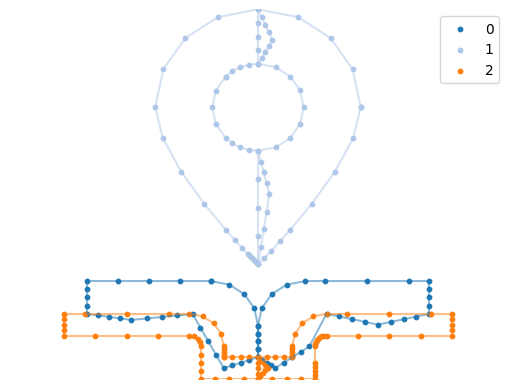

In [11]:
# plot graph
from matplotlib.lines import Line2D
from collections import OrderedDict

tab20 = [plt.cm.tab20(x) for x in range(20)]

fig = plt.figure("plot_graph")
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")
plt.axis([min(h[:,3])-3, max(h[:,3])+3, max(h[:,4]), min(h[:,4])])
        
# graph nodes
for k, v in node_group.items():
    for n in v:
        x, y = G_point.nodes[n]['features']['pos']
        plt.scatter(x, y, color=tab20[k], s=10, label=k)
        
    # group edges
    for kk, vv in edge_type.items():
        if kk[0] in v and vv == "group":        
            x1, y1 = G_point.nodes[kk[0]]['features']['pos']
            x2, y2 = G_point.nodes[kk[1]]['features']['pos']
            l = Line2D((x1,x2), (y1,y2), color=tab20[k%20], alpha=0.5)
            ax.add_line(l)

# for node in G_group.nodes:
#     xx, yy = G_group.nodes[node]['features']['pos'][:,0], G_group.nodes[node]['features']['pos'][:,1]
#     plt.scatter(xx, yy, color=tab20[node], s=10, label=node)    
    
# for k, v in node_group.items():
#     for i in range(len(v)-1):
#         x1, y1 = G_point.nodes[v[i]]['features']['pos']
#         x2, y2 = G_point.nodes[v[i+1]]['features']['pos']
#         l = Line2D([x1,x2], [y1,y2], color=tab20[k], alpha=0.5)
#         ax.add_line(l)
#     x1, y1 = G_point.nodes[v[0]]['features']['pos']
#     x2, y2 = G_point.nodes[v[-1]]['features']['pos']
#     l = Line2D([x1,x2], [y1,y2], color=tab20[k], alpha=0.5)
#     ax.add_line(l)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()
plt.close()

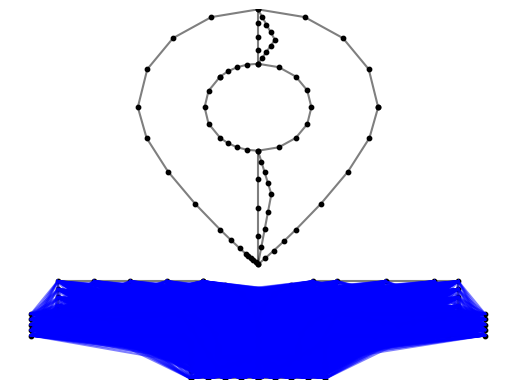

In [12]:
# plot edges between cluster
fig = plt.figure("plot_graph")
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")
plt.axis([min(h[:,3])-1, max(h[:,3])+1, max(h[:,4]), min(h[:,4])])

# graph nodes and group edges
for node in G_group.nodes:
    xx, yy = G_group.nodes[node]['features']['pos'][:,0], G_group.nodes[node]['features']['pos'][:,1]
    plt.scatter(xx, yy, c="black", s=10)

# cluster edges
for k, v in edge_type.items():
    if v == "group":  # group edges
        x1, y1 = G_point.nodes[k[0]]['features']['pos']
        x2, y2 = G_point.nodes[k[1]]['features']['pos']
        l = Line2D([x1,x2], [y1,y2], c="black", alpha=0.5)
        ax.add_line(l)
    elif v == "contain":  # contain
        x1, y1 = G_point.nodes[k[0]]['features']['pos']
        x2, y2 = G_point.nodes[k[1]]['features']['pos']
        l = Line2D([x1,x2], [y1,y2], c="red", alpha=0.5)
        ax.add_line(l)
    elif v == "overlap":  # overlap
        x1, y1 = G_point.nodes[k[0]]['features']['pos']
        x2, y2 = G_point.nodes[k[1]]['features']['pos']
        l = Line2D([x1,x2], [y1,y2], c="blue", alpha=0.5)
        ax.add_line(l)
        
plt.show()
plt.close()